In [41]:
import numpy as np
import matplotlib.pyplot as plt
from GraphDomain import EncodePriority
import os

In [42]:
np.random.seed(0)

In [43]:
sc = "Datasets/IDPCDU_Edges/set1/"
TaskNames = os.listdir(sc)
TaskNames

['idpc_10x10x1000.idpc',
 'idpc_10x20x2713.idpc',
 'idpc_10x5x425.idpc',
 'idpc_15x15x3375.idpc',
 'idpc_15x30x12111.idpc',
 'idpc_15x7x1504.idpc',
 'idpc_20x10x2492.idpc',
 'idpc_20x20x8000.idpc',
 'idpc_20x40x26104.idpc',
 'idpc_25x12x4817.idpc',
 'idpc_25x25x15625.idpc',
 'idpc_25x50x57147.idpc',
 'idpc_30x15x10025.idpc',
 'idpc_30x30x27000.idpc',
 'idpc_30x60x89772.idpc',
 'idpc_35x17x13934.idpc',
 'idpc_35x35x42875.idpc',
 'idpc_35x70x123585.idpc',
 'idpc_40x20x18485.idpc',
 'idpc_40x40x64000.idpc',
 'idpc_40x80x130681.idpc',
 'idpc_45x22x43769.idpc',
 'idpc_45x45x91125.idpc',
 'idpc_45x90x322081.idpc']

In [44]:
def Load(index):
    path = sc + TaskNames[index]
    name = TaskNames[index].split('.')[0]
    task = EncodePriority(path=path, name=name)
    return task

Task = Load(2)
Task.NAME

'idpc_10x5x425'

In [104]:
def GeneratorPopulaion(sizePop, dims=Task.NUM_DOMAIN, task=Task):
    Populaion = []
    for i in range(sizePop):
        pi = np.random.permutation(range(1, dims+1))
        f_pi = task.Cost(pi)
        Populaion.append((pi, f_pi))

    return Populaion

In [46]:
Task = Load(0)
Task.NAME

'idpc_10x10x1000'

In [47]:
np.set_printoptions(linewidth=np.inf)
GeneratorPopulaion(5)

[(array([3, 1, 2, 4, 5]), 14.0),
 (array([1, 3, 2, 5, 4]), 13.0),
 (array([2, 4, 5, 1, 3]), 14.0),
 (array([4, 2, 3, 5, 1]), 14.0),
 (array([5, 3, 4, 2, 1]), 14.0)]

In [52]:
def chooseParents(pop):
    n = len(pop)
    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)
    
    index3 = np.random.randint(n)
    index4 = np.random.randint(n)
    while index3 == index4:
        index4 = np.random.randint(n)
    
    if pop[index1][1] < pop[index2][1]:
        p1 = pop[index1][0]
    else:
        p1 = pop[index2][0]
    
    if pop[index3][1] < pop[index4][1]:
        p2 = pop[index3][0]
    else:
        p2 = pop[index4][0]
    
    return p1, p2

In [53]:
def cross_pmx(p1, p2):
    n = len(p1)
    
    index1 = np.random.randint(1, n-1)
    index2 = np.random.randint(1, n-1)
    while index1 == index2:
       index2 = np.random.randint(1, n-1)
   
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp

    #print(index1, index2)

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2

In [54]:
def paradox_mutation(indiv):
    n = len(indiv)
    index1 = np.random.randint(1, n-1)
    index2 = np.random.randint(1, n-1)
    while index1 == index2:
       index2 = np.random.randint(1, n-1)
   
    if index1 > index2:
        temp = index1
        index1 = index2
        index2 = temp

    while index1 < index2:
        temp = indiv[index1]
        indiv[index1] = indiv[index2]
        indiv[index2] = temp
        index1 += 1
        index2 -= 1

    return indiv


In [97]:
def selection(pre_pop, offs_pop, rate_sel = 0.3):  
    n = len(pre_pop)
    # n_p = int(n*rate_sel)
    # n_o = int(n*(0.5 - rate_sel))
    # pre_pop.sort(key=lambda tup: tup[1])
    # offs_pop.sort(key=lambda tup: tup[1])
    # pop = pre_pop[n_p:] + offs_pop[n_o:]
    # pop.sort(key=lambda tup: tup[1])
    # next_pop = pre_pop[0:n_p] + offs_pop[0:n_o] + pop[0:(n-n_p-n_o)]

    pop = offs_pop + pre_pop
    pop.sort(key=lambda tup: tup[1])
    next_pop = pop[:n]

    return next_pop

In [110]:
from tqdm import tqdm

def GA(size_pop, num_gens, Pc, Pm, task=Task):
    population = GeneratorPopulaion(size_pop, task=task)
    logg = []

    for t in tqdm(range(num_gens)):
        offs_pop = []
        while len(offs_pop) < size_pop:
            p1, p2 = chooseParents(population)

            rand = np.random.random_sample()
            o1, o2 = [], []
            if rand <= Pc:
                o1, o2 = cross_pmx(p1, p2)
            else:
                o1 = paradox_mutation(p1)
                o2 = paradox_mutation(p2)
            if np.random.random_sample() < Pm:
                o1 = paradox_mutation(o1)
                o2 = paradox_mutation(o2)
            
            offs_pop.append((o1, task.Cost(o1)))
            offs_pop.append((o2, task.Cost(o2)))
        
        population = selection(population, offs_pop)
        logg.append([t, population[0]])
    
    return logg

In [57]:
def show(his):
    input = np.array(his, dtype=object)
    x = input[:, 0]
    y = np.array(input[:, 1])
    y = [i[1] for i in y]
    plt.plot(x, y)
    plt.title(Task.NAME + ": best = {}".format(his[-1][1][1]))
    plt.show()

In [76]:
np.random.seed(None)

In [123]:
Task = Load(0)
Task.NAME

'idpc_10x10x1000'

100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


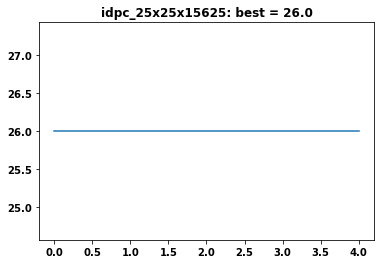

In [116]:
history = GA(1000, 5, 0.7, 0.5, task=Task)
show(history)

In [117]:
history[-1]

[4,
 (array([66, 67, 50,  9, 21, 85, 26, 10, 87, 35, 63,  2, 12, 55, 79,  3, 59, 62, 57, 19, 81, 75, 37, 25, 83, 52, 42, 41, 24, 58,  6, 34, 53, 65, 49, 38, 73, 17, 89, 40, 29, 77, 23,  4, 71, 11, 14, 64,  1, 22, 74,  7, 69, 90, 78, 61, 31, 82,  5, 54, 30, 32, 72, 60, 36, 28, 45, 51, 47, 43, 18, 16, 56, 68, 39, 48, 13, 84, 33, 20,  8, 86, 88, 70, 80, 46, 76, 27, 15, 44]),
  26.0)]